# BERT NLP on Verbal Autopsy Dataset for Social Determinants of Health

---



#### Connecting to Google Accounts
Authenticating Google account and copying the dataset .csv file to the Colab working directory:

In [1]:
from google.colab import auth
auth.authenticate_user()

!mkdir -p data/processed
!gsutil cp gs://kind-lab-data/verbal-autopsy-sdoh/merged_dataset.csv ./data/processed/

Copying gs://kind-lab-data/verbal-autopsy-sdoh/merged_dataset.csv...
/ [1 files][  4.1 MiB/  4.1 MiB]                                                
Operation completed over 1 objects/4.1 MiB.                                      


### Setup

#### Installing & Importing Dependencies

In [2]:
!pip install transformers evaluate transformers_interpret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 9.0 MB/s 
     |████████████████████████████████| 72 kB 1.6 MB/s 
     |████████████████████████████████| 45 kB 4.4 MB/s 
     |████████████████████████████████| 7.6 MB 52.8 MB/s 
     |████████████████████████████████| 163 kB 73.4 MB/s 
     |████████████████████████████████| 441 kB 69.3 MB/s 
     |████████████████████████████████| 115 kB 72.7 MB/s 
     |████████████████████████████████| 212 kB 60.8 MB/s 
     |████████████████████████████████| 95 kB 5.1 MB/s 
     |████████████████████████████████| 127 kB 73.3 MB/s 
     |████████████████████████████████| 1.4 MB 54.8 MB/s 
     |████████████████████████████████| 793 kB 67.3 MB/s 
     |████████████████████████████████| 1.6 MB 56.6 MB/s 
     |████████████████████████████████| 115 kB 75.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling

In [3]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# from numpy.random import default_rng
# rng = default_rng(87)

import evaluate
from transformers import AutoTokenizer
from transformers import BertForSequenceClassification, Trainer, TrainingArguments, RobertaForSequenceClassification

import torch

#### Dataset Exploration

In [4]:
df = pd.read_csv('data/processed/merged_dataset.csv')
df

,newid,site,sex,age_years,age_months,age_days,gs_text34,open_response,g1_01d,g1_01m,...,g5_01y,g5_02,g5_03d,g5_03m,g5_03y,g5_04a,g5_04b,g5_04c,g5_06a,g5_06b
0,1,Mexico,Male,51.0,NaN,NaN,Cirrhosis,no comments.[PERSON] only told us what happene...,17.0,August,...,1958.0,Male,NaN,September,2009.0,51.0,NaN,NaN,Primary School,Don't Know
1,2,AP,Male,24.0,NaN,NaN,Epilepsy,[PATIENT] was suffering for the last two years...,NaN,NaN,...,NaN,Male,19.0,November,2008.0,24.0,NaN,NaN,No Schooling,0
2,3,AP,Female,62.0,NaN,NaN,Pneumonia,she has stopped consuming tablets for b.p and ...,NaN,NaN,...,NaN,Female,7.0,October,2008.0,62.0,NaN,NaN,No Schooling,0
3,4,Mexico,Female,80.0,NaN,NaN,COPD,my mother's condition was already very poor du...,23.0,June,...,1923.0,Female,19.0,January,2009.0,80.0,NaN,NaN,No Schooling,0
4,5,UP,Male,76.0,NaN,NaN,Acute Myocardial Infarction,the deceased suffered a heart attack 2 days ag...,2.0,October,...,1933.0,Male,21.0,April,2009.0,76.0,NaN,NaN,High School,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6805,7842,Mexico,Female,52.0,NaN,NaN,Cervical Cancer,my aunt had been diabetic for the past 9 year....,6.0,July,...,1957.0,Female,22.0,September,2009.0,52.0,NaN,NaN,No Schooling,0
6806,7843,Dar,Female,78.0,NaN,NaN,Other Cardiovascular Diseases,the participant had nothing to comment on_x000...,-1.0,Don't Know,...,1930.0,Female,3.0,November,2008.0,78.0,NaN,NaN,Primary School,0
6807,7844,AP,Female,25.0,NaN,NaN,Poisonings,she opened the tailoring shop in the center be...,NaN,NaN,...,1984.0,Female,2.0,February,2009.0,25.0,NaN,NaN,High School,0
6808,7845,UP,Female,22.0,NaN,NaN,Fires,the deceased had been suffering from pain in t...,16.0,May,...,1987.0,Female,16.0,August,2009.0,22.0,NaN,NaN,No Schooling,0


Determining lengths of records in the dataset using RoBERTa:

In [5]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
sentences = df['open_response'].tolist()
encoded = tokenizer(sentences, truncation=False)

seq_lengths = [np.count_nonzero(x) for x in encoded['input_ids']]
idx_long_seq = [i for i, x in enumerate(seq_lengths) if x > 512]
print(f'{len(idx_long_seq)} sentences longer than 512 tokens.')
print(f'Lengths: {sorted([seq_lengths[i] for i in idx_long_seq])}')
# for i in idx_long_seq[:1]:
#      print(tokenizer.decode(encoded['input_ids'][i]))


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors


27 sentences longer than 512 tokens.
Lengths: [513, 518, 519, 520, 521, 521, 526, 529, 532, 533, 535, 543, 543, 544, 545, 545, 551, 559, 559, 573, 583, 592, 597, 604, 622, 627, 803]


And using BERT:

In [6]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
sentences = df['open_response'].tolist()
encoded = tokenizer(sentences, truncation=False)

seq_lengths = [np.count_nonzero(x) for x in encoded['input_ids']]
idx_long_seq = [i for i, x in enumerate(seq_lengths) if x > 512]
print(f'{len(idx_long_seq)} sentences longer than 512 tokens.')
print(f'Lengths: {sorted([seq_lengths[i] for i in idx_long_seq])}')
# for i in idx_long_seq[:1]:
#      print(tokenizer.decode(encoded['input_ids'][i]))


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (531 > 512). Running this sequence through the model will result in indexing errors


20 sentences longer than 512 tokens.
Lengths: [513, 521, 528, 531, 532, 537, 539, 541, 545, 556, 558, 559, 561, 569, 572, 576, 580, 597, 614, 953]


There are a few records that have sequence lengths longer than 512. Given the small number of records, we decide to truncate directly rather than splitting the sentences in some way.
 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


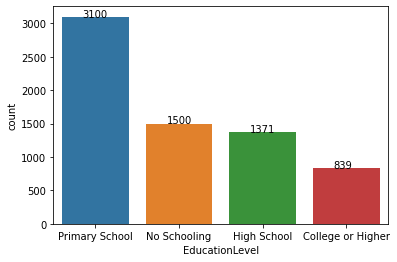

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.countplot(df.g5_06a)
for p in ax.patches:
   ax.annotate('{:1d}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()))
plt.xlabel('EducationLevel');

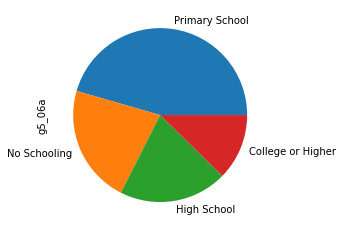

In [8]:
df['g5_06a'].value_counts().plot(kind='pie')



---



### Predicting Education Level - 4 Classes

#### HuggingFace Dataset
Encoding labels:

In [9]:
documents = df['open_response'].tolist()
label2id = {
    'No Schooling': 0,
    'Primary School': 1,
    'High School': 2,
    'College or Higher': 3
}
labels = df['g5_06a'].map(label2id).tolist()

Splitting data into Train/Validation/Test according to 68%/17%/15%:

In [ ]:
# create train/test split
train_texts, test_texts, train_labels, test_labels = train_test_split(documents, labels, test_size=.15, random_state=8573)

# create train/validation split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2, random_state=3820)

Encoding documents using BERT tokenizer:

In [ ]:
# tokenize 
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

Defining dataset object compatible with HuggingFace: 

In [ ]:
# create a class for the dataset -> compatible with huggingface trainer
class VerbalAutopsyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = VerbalAutopsyDataset(train_encodings, train_labels)
val_dataset = VerbalAutopsyDataset(val_encodings, val_labels)
test_dataset = VerbalAutopsyDataset(test_encodings, test_labels)

#### Model Tuning
Fine-tuning BERT model:

In [ ]:
start_time = time.time()
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    evaluation_strategy='steps',
    eval_steps=100,
)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()
print(f"Time Elapsed: {time.time() - start_time}")

Freezing all but final classifier layer in BERT:

In [ ]:
start_time = time.time()
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    evaluation_strategy='steps',
    eval_steps=100,
)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)

# freezing all but final classifier layer
for name, param in model.named_parameters():
	if 'classifier' not in name: # classifier layer
		param.requires_grad = False

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()
print(f"Time Elapsed: {time.time() - start_time}")

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Step,Training Loss,Validation Loss
100,1.289800,1.286581
200,1.282600,1.274488
300,1.264100,1.267493
400,1.251600,1.261712
500,1.265100,1.259783
600,1.257600,1.260774
700,1.246700,1.263678


***** Running Evaluation *****
  Num examples = 1158
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1158
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1158
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1158
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1158
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1158
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1158
  Batch size = 64


KeyboardInterrupt: ignored

#### F1 Performance Score

In [ ]:
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
f1_metric = evaluate.load("f1")
results = f1_metric.compute(predictions=preds, references=predictions.label_ids, average='weighted')
print(results)

***** Running Prediction *****
  Num examples = 1022
  Batch size = 64


(1022, 4) (1022,)


#### Plot Training/Validation Curves

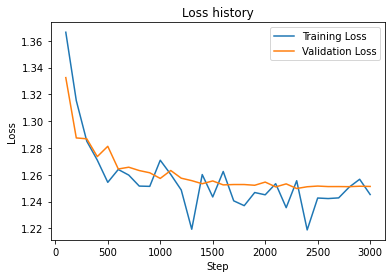

In [ ]:
import matplotlib.pyplot as plt
history = pd.read_excel('Temp.xlsx')
plt.plot(history['Step'], history['Training Loss'], label='Training Loss')
plt.plot(history['Step'], history['Validation Loss'], label='Validation Loss')

plt.title('Loss history')
plt.ylabel('Loss')
plt.xlabel('Step')
plt.legend()

#### Visualize Explanations


Picking the highest predicted value for each class:

In [ ]:
id2label = {v: k for k, v in label2id.items()}
print(id2label)

from transformers_interpret import SequenceClassificationExplainer
multiclass_explainer = SequenceClassificationExplainer(model=model, tokenizer=tokenizer)
max_predictions = predictions.predictions.max(0)
print(max_predictions)

examples = {}
for each_class in id2label.keys():
    examples[each_class] = {}
    examples[each_class]['max'] = int(np.where(predictions.predictions[:, each_class] == max_predictions[each_class])[0])

{'No Schooling': 0,
 'Primary School': 1,
 'High School': 2,
 'College or Higher': 3}

Visualizing explanations for the max sample in each class:

In [ ]:
model.to('cpu')
for each_class in examples.keys():
    for each_example in examples[each_class].keys():
        text_example = test_texts[examples[each_class][each_example]]
        word_attributions = multiclass_explainer(text=text_example)
        print(f"Prediction for the {each_example} predicted value example of class {each_class}: {multiclass_explainer.predicted_class_name}")
        html = multiclass_explainer.visualize()

Prediction for the max predicted value example of class 0: LABEL_0


RuntimeError: ignored



---



### Predicting Education Level - 2 Classes (Binarized)


#### HuggingFace Dataset
Encoding labels:

In [ ]:
documents = df['open_response'].tolist()
label2id = {
    'No Schooling': 0,
    'Primary School': 0,
    'High School': 1,
    'College or Higher': 1
}
labels = df['g5_06a'].map(label2id).tolist()

Splitting data into Train/Validation/Test according to 68%/17%/15%:

In [ ]:
# create train/test split
train_texts, test_texts, train_labels, test_labels = train_test_split(documents, labels, test_size=.15, random_state=8573)

# create train/validation split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2, random_state=3820)

Encoding documents using RoBERTa tokenizer:

In [ ]:
# tokenize 
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

Or using BERT tokenizer:

In [ ]:
# tokenize 
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

Defining dataset object compatible with HuggingFace: 

In [ ]:
# create a class for the dataset -> compatible with huggingface trainer
class VerbalAutopsyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = VerbalAutopsyDataset(train_encodings, train_labels)
val_dataset = VerbalAutopsyDataset(val_encodings, val_labels)
test_dataset = VerbalAutopsyDataset(test_encodings, test_labels)

#### Model Tuning
Fine-tuning BERT model:

In [ ]:
start_time = time.time()
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.001,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    evaluation_strategy='steps',
    eval_steps=100,
)

model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()
print(f"Time Elapsed: {time.time() - start_time}")

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Step,Training Loss,Validation Loss
100,0.636800,0.608847
200,0.651800,0.605526
300,0.622000,0.600146
400,0.609000,0.602899
500,0.651100,0.694626
600,0.631600,0.624061


***** Running Evaluation *****
  Num examples = 1158
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1158
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1158
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1158
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1158
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1158
  Batch size = 64


KeyboardInterrupt: ignored

Freezing all but final classifier layer in BERT:

In [ ]:
start_time = time.time()
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=64,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.0001,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    evaluation_strategy='steps',
    eval_steps=100,
)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# freezing all but final classifier layer
for name, param in model.named_parameters():
	if 'classifier' not in name: # classifier layer
		param.requires_grad = False

# for name, param in model.named_parameters():
#   if 'classifier' not in name: # classifier layer
#     assert param.requires_grad == False
#   else:
#     assert param.requires_grad == True

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()
print(f"Time Elapsed: {time.time() - start_time}")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/5546055f03398095e385d7dc625e636cc8910bf2/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_ve

Step,Training Loss,Validation Loss
100,0.671900,0.651727
200,0.644300,0.629126
300,0.627100,0.615452
400,0.621200,0.609356
500,0.622100,0.607892
600,0.620500,0.607612
700,0.616900,0.607456


***** Running Evaluation *****
  Num examples = 1158
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1158
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1158
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1158
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1158
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1158
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1158
  Batch size = 64


Training completed. Do not forget to share your model on huggingface.co/models =)




Time Elapsed: 1968.357655286789


#### F1 Performance Score

In [ ]:
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
f1_metric = evaluate.load("f1")
results = f1_metric.compute(predictions=preds, references=predictions.label_ids, average='weighted')
print(results)

***** Running Prediction *****
  Num examples = 1022
  Batch size = 64


{'f1': 0.5128169286682006}


#### Plot Training/Validation Curves

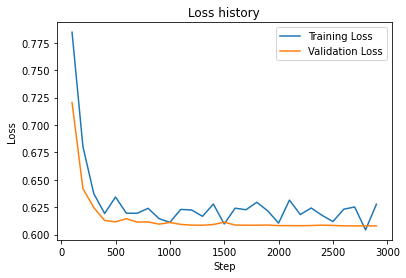

In [ ]:
import matplotlib.pyplot as plt
history = pd.read_excel('Temp.xlsx')
plt.plot(history['Step'], history['Training Loss'], label='Training Loss')
plt.plot(history['Step'], history['Validation Loss'], label='Validation Loss')

plt.title('Loss history')
plt.ylabel('Loss')
plt.xlabel('Step')
plt.legend()

#### Visualize Explanations


Picking the highest predicted value for each class:

In [ ]:
id2label = {v: k for k, v in label2id.items()}
print(id2label)

from transformers_interpret import SequenceClassificationExplainer
multiclass_explainer = SequenceClassificationExplainer(model=model, tokenizer=tokenizer)
max_predictions = predictions.predictions.max(0)
print(max_predictions)

examples = {}
for each_class in id2label.keys():
    examples[each_class] = {}
    examples[each_class]['max'] = int(np.where(predictions.predictions[:, each_class] == max_predictions[each_class])[0])

{'No Schooling': 0,
 'Primary School': 1,
 'High School': 2,
 'College or Higher': 3}

Visualizing explanations for the max sample in each class:

In [ ]:
model.to('cpu')
for each_class in examples.keys():
    for each_example in examples[each_class].keys():
        text_example = test_texts[examples[each_class][each_example]]
        word_attributions = multiclass_explainer(text=text_example)
        print(f"Prediction for the {each_example} predicted value example of class {each_class}: {multiclass_explainer.predicted_class_name}")
        html = multiclass_explainer.visualize()

Prediction for the max predicted value example of class 0: LABEL_0


RuntimeError: ignored



---



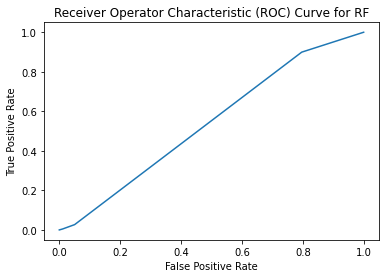

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve

fpr, tpr, thresholds = roc_curve(test_labels, best_predictions, pos_label = 1)

plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic (ROC) Curve for RF')
plt.show()

### Predicting Gender - 2 Classes


#### HuggingFace Dataset
Encoding labels:

In [ ]:
print(f"Possible genders: {list(df['g5_02'].unique())}")
df[~df['g5_02'].isin(['Male', 'Female'])]
df_filtered = df[df['g5_02'].isin(['Male', 'Female'])]

Possible genders: ['Male', 'Female', nan]


In [ ]:
documents = df_filtered['open_response'].tolist()
label2id = {
    'Male': 0,
    'Female': 1
}
labels = df_filtered['g5_02'].map(label2id).tolist()

Splitting data into Train/Validation/Test according to 68%/17%/15%:

In [ ]:
# create train/test split
train_texts, test_texts, train_labels, test_labels = train_test_split(documents, labels, test_size=.15, random_state=8573)

# create train/validation split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2, random_state=3820)

Encoding documents using BERT tokenizer:

In [ ]:
# tokenize 
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

Defining dataset object compatible with HuggingFace: 

In [ ]:
# create a class for the dataset -> compatible with huggingface trainer
class VerbalAutopsyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = VerbalAutopsyDataset(train_encodings, train_labels)
val_dataset = VerbalAutopsyDataset(val_encodings, val_labels)
test_dataset = VerbalAutopsyDataset(test_encodings, test_labels)

#### Model Tuning
Fine-tuning BERT model:

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
start_time = time.time()
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    learning_rate=2e-5,
    evaluation_strategy='steps',
    eval_steps=100,
    load_best_model_at_end=True,
)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()
print(f"Time Elapsed: {time.time() - start_time}")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Step,Training Loss,Validation Loss


KeyboardInterrupt: ignored

Freezing all but final classifier layer in BERT:

In [ ]:
start_time = time.time()
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    learning_rate=2e-5,
    evaluation_strategy='steps',
    eval_steps=100,
    load_best_model_at_end=True,
)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# freezing all but final classifier layer
for name, param in model.named_parameters():
	if 'classifier' not in name: # classifier layer
		param.requires_grad = False

for name, param in model.named_parameters():
     print(name, param.requires_grad)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()
print(f"Time Elapsed: {time.time() - start_time}")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/5546055f03398095e385d7dc625e636cc8910bf2/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_ve

bert.embeddings.word_embeddings.weight False
bert.embeddings.position_embeddings.weight False
bert.embeddings.token_type_embeddings.weight False
bert.embeddings.LayerNorm.weight False
bert.embeddings.LayerNorm.bias False
bert.encoder.layer.0.attention.self.query.weight False
bert.encoder.layer.0.attention.self.query.bias False
bert.encoder.layer.0.attention.self.key.weight False
bert.encoder.layer.0.attention.self.key.bias False
bert.encoder.layer.0.attention.self.value.weight False
bert.encoder.layer.0.attention.self.value.bias False
bert.encoder.layer.0.attention.output.dense.weight False
bert.encoder.layer.0.attention.output.dense.bias False
bert.encoder.layer.0.attention.output.LayerNorm.weight False
bert.encoder.layer.0.attention.output.LayerNorm.bias False
bert.encoder.layer.0.intermediate.dense.weight False
bert.encoder.layer.0.intermediate.dense.bias False
bert.encoder.layer.0.output.dense.weight False
bert.encoder.layer.0.output.dense.bias False
bert.encoder.layer.0.output.Lay

***** Running training *****
  Num examples = 4624
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2890
  Number of trainable parameters = 1538


Step,Training Loss,Validation Loss
100,0.702900,0.693908
200,0.691700,0.692910
300,0.689300,0.691356
400,0.685400,0.688838
500,0.687700,0.683921
600,0.681400,0.683953
700,0.673900,0.685982
800,0.672000,0.679145
900,0.674800,0.674348
1000,0.670600,0.676338


***** Running Evaluation *****
  Num examples = 1156
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1156
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1156
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1156
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1156
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1156
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1156
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1156
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1156
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1156
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.jso

Time Elapsed: 2637.6054966449738


#### F1 Performance Score

In [ ]:
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
f1_metric = evaluate.load("f1")
results = f1_metric.compute(predictions=preds, references=predictions.label_ids, average='weighted')
print(results)

***** Running Prediction *****
  Num examples = 1020
  Batch size = 8


{'f1': 0.6218308697088384}


In [ ]:
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
f1_metric = evaluate.load("f1")
results = f1_metric.compute(predictions=preds, references=predictions.label_ids, average='weighted')
print(results)

***** Running Prediction *****
  Num examples = 1020
  Batch size = 64


Step,Training Loss,Validation Loss
100,0.640200,0.485335
200,0.448400,0.466381
300,0.420900,0.417709
400,0.394300,0.386431
500,0.413200,0.425894
600,0.396500,0.378334
700,0.385900,0.383508
800,0.370400,0.410797
900,0.351500,0.492856
1000,0.330300,0.433072


{'f1': 0.788472787429817}


#### Plot Training/Validation Curves

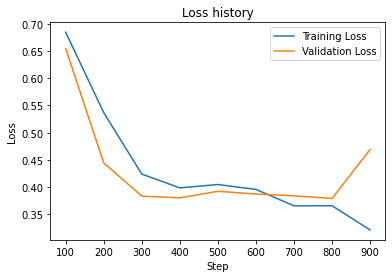

In [ ]:
import matplotlib.pyplot as plt
history = pd.read_excel('Temp.xlsx')
plt.plot(history['Step'], history['Training Loss'], label='Training Loss')
plt.plot(history['Step'], history['Validation Loss'], label='Validation Loss')

plt.title('Loss history')
plt.ylabel('Loss')
plt.xlabel('Step')
plt.legend()

#### Visualize Explanations


Picking the highest predicted value for each class:

In [ ]:
import numpy as np
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

print(find_nearest(predictions.predictions[:, 0], value=0))

0.0001351205


In [ ]:
id2label = {v: k for k, v in label2id.items()}
print(id2label)

from transformers_interpret import SequenceClassificationExplainer
multiclass_explainer = SequenceClassificationExplainer(model=model, tokenizer=tokenizer)

examples = {}
for each_class in id2label.keys():
    max_prediction = find_nearest(predictions.predictions[:, each_class], value=each_class)
    print(max_prediction)
    examples[each_class] = {}
    examples[each_class]['max'] = int(np.where(predictions.predictions[:, each_class] == max_prediction)[0])

{0: 'Male', 1: 'Female'}
0.0001351205
0.33292553


Visualizing explanations for the max sample in each class:

In [ ]:
model.to('cuda')
for each_class in examples.keys():
    for each_example in examples[each_class].keys():
        text_example = test_texts[examples[each_class][each_example]]
        word_attributions = multiclass_explainer(text=text_example)
        print(f"Prediction for the {each_example} predicted value example of class {each_class}: {multiclass_explainer.predicted_class_name}")
        html = multiclass_explainer.visualize()

Prediction for the max predicted value example of class 0: LABEL_1


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_1 (0.57),LABEL_1,2.32,[CLS] the client thanked for services which provided by nurses doctors in the hospital [SEP]


Prediction for the max predicted value example of class 1: LABEL_1


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_1 (0.52),LABEL_1,0.98,[CLS] participant satisfied with the services provided at the hospital [SEP]




---



# Baseline TF-IDF Model


### Imports & Setup

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, precision_recall_fscore_support
from nltk.stem.snowball import EnglishStemmer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Classification of Education Level - 4 Classes
Splitting data and encoding labels:

In [ ]:
documents = df['open_response'].tolist()
label2id = {
    'No Schooling': 0,
    'Primary School': 1,
    'High School': 2,
    'College or Higher': 3
}
labels = df['g5_06a'].map(label2id).tolist()

# create train/test split
train_texts, test_texts, train_labels, test_labels = train_test_split(documents, labels, test_size=.15, random_state=8573)

# create train/validation split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2, random_state=3820)

Defining analyzer with stemmer:

In [ ]:
stemmer = EnglishStemmer()
analyzer = CountVectorizer().build_analyzer()
def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

Defining NLP pipeline and grid search parameters, fitting model:

In [ ]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(analyzer=stemmed_words)),
    ('tfidf', TfidfTransformer()),
    ('multi_regression', LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter = 100000)) #one vs rest
])

parameters = {'multi_regression__C': [0.01, 0.1, 0.5, 1, 2, 5, 10, 100, 1000], # other parameters? inverse of l2 regularization, larger C more prone to overfit
              'vectorizer__stop_words': ['english'],
              'vectorizer__max_features': [500]}

pipeline_gridsearch_cv = GridSearchCV(pipeline, parameters, cv=5, verbose=1)
pipeline_gridsearch_cv.fit(train_texts, train_labels)
best_predictions = pipeline_gridsearch_cv.predict(test_texts)

baseline_accuracy = np.mean(best_predictions == test_labels)
print("TF-IDF Accuracy:", baseline_accuracy)
print(classification_report(test_labels, best_predictions))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
TF-IDF Accuracy: 0.45499021526418787
              precision    recall  f1-score   support

           0       0.44      0.29      0.35       215
           1       0.46      0.88      0.61       447
           2       0.21      0.03      0.05       206
           3       0.80      0.03      0.05       154

    accuracy                           0.45      1022
   macro avg       0.48      0.31      0.26      1022
weighted avg       0.46      0.45      0.36      1022



Printing feature words:

In [ ]:
with np.printoptions(threshold=np.inf):
    print(pipeline_gridsearch_cv.best_estimator_.named_steps['vectorizer'].get_feature_names_out())

['00' '10' '11' '12' '15' '20' '2007' '2008' '2009' '30' '_x000d_'
 '_x000d__x000d_' 'abdomen' 'abdomin' 'abl' 'about' 'accid' 'accord' 'add'
 'addit' 'admit' 'advis' 'affect' 'after' 'afternoon' 'again' 'age' 'ago'
 'aid' 'alcohol' 'all' 'alreadi' 'also' 'alway' 'am' 'amount' 'an' 'and'
 'ani' 'anoth' 'answer' 'anymor' 'anyth' 'appear' 'appetit' 'april' 'are'
 'around' 'arriv' 'as' 'ask' 'asthma' 'at' 'attack' 'attent' 'away' 'babi'
 'back' 'bad' 'be' 'becam' 'becaus' 'becom' 'bed' 'been' 'befor' 'began'
 'better' 'birth' 'bleed' 'blood' 'bodi' 'both' 'bp' 'brain' 'breast'
 'breath' 'bring' 'brother' 'brought' 'burn' 'but' 'by' 'call' 'came'
 'can' 'cancer' 'cannot' 'care' 'caus' 'certif' 'chang' 'check'
 'chemotherapi' 'chest' 'child' 'client' 'clot' 'cold' 'color' 'coma'
 'come' 'comment' 'complain' 'complet' 'condit' 'confin' 'conscious'
 'consult' 'consum' 'continu' 'control' 'convuls' 'cough' 'could' 'ct'
 'cure' 'damag' 'date' 'daughter' 'day' 'dead' 'death' 'deceas' 'decemb'
 '

### Classification of Education Level - 2 Classes (Binarized)
Splitting data and encoding labels:

In [ ]:
documents = df['open_response'].tolist()
label2id = {
    'No Schooling': 0,
    'Primary School': 0,
    'High School': 1,
    'College or Higher': 1
}
labels = df['g5_06a'].map(label2id).tolist()

# create train/test split
train_texts, test_texts, train_labels, test_labels = train_test_split(documents, labels, test_size=.15, random_state=8573)

# create train/validation split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2, random_state=3820)

Defining analyzer with stemmer:

In [ ]:
stemmer = EnglishStemmer()
analyzer = CountVectorizer().build_analyzer()
def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

Defining NLP pipeline and grid search parameters, fitting model:

In [ ]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(analyzer=stemmed_words)),
    ('tfidf', TfidfTransformer()),
    ('binary_regression', LogisticRegression(solver="lbfgs", max_iter=100000)) #one vs rest
])

parameters = {'binary_regression__C': [0.01, 0.1, 0.5, 1, 2, 5, 10, 100, 1000], # other parameters? inverse of l2 regularization, larger C more prone to overfit
              'vectorizer__stop_words': ['english'],
              'vectorizer__max_features': [100]}

pipeline_gridsearch_cv = GridSearchCV(pipeline, parameters, cv=5, verbose=1)
pipeline_gridsearch_cv.fit(train_texts, train_labels)
best_predictions = pipeline_gridsearch_cv.predict(test_texts)

baseline_accuracy = np.mean(best_predictions == test_labels)
print("TF-IDF Accuracy:", baseline_accuracy)
print(classification_report(test_labels, best_predictions))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
TF-IDF Accuracy: 0.6575342465753424
              precision    recall  f1-score   support

           0       0.66      0.98      0.79       662
           1       0.66      0.06      0.11       360

    accuracy                           0.66      1022
   macro avg       0.66      0.52      0.45      1022
weighted avg       0.66      0.66      0.55      1022



Printing feature words:

In [ ]:
with np.printoptions(threshold=np.inf):
    print(pipeline_gridsearch_cv.best_estimator_.named_steps['vectorizer'].get_feature_names_out())

['admit' 'after' 'again' 'alreadi' 'also' 'an' 'and' 'are' 'as' 'at' 'be'
 'becam' 'becaus' 'been' 'befor' 'blood' 'bodi' 'breath' 'brought' 'but'
 'by' 'client' 'day' 'death' 'deceas' 'did' 'die' 'difficulti' 'doctor'
 'due' 'even' 'fever' 'for' 'from' 'given' 'got' 'had' 'has' 'have' 'he'
 'heart' 'her' 'him' 'his' 'home' 'hospit' 'hospital2' 'in' 'interview'
 'is' 'it' 'last' 'medicin' 'month' 'my' 'no' 'not' 'of' 'on' 'one' 'onli'
 'oper' 'out' 'pain' 'patient' 'place' 'problem' 'said' 'servic' 'she'
 'sinc' 'so' 'start' 'suffer' 'take' 'taken' 'that' 'the' 'then' 'there'
 'they' 'this' 'time' 'to' 'told' 'took' 'treatment' 'up' 'us' 'use'
 'veri' 'was' 'we' 'went' 'were' 'when' 'which' 'with' 'would' 'year']


### Classification of Gender - 2 Classes


There are a few records that have NaN as gender. Given the low number of records (10), they will be removed before model fitting.

In [ ]:
print(f"Possible genders: {list(df['g5_02'].unique())}")

Possible genders: ['Male', 'Female', nan]


In [ ]:
df[~df['g5_02'].isin(['Male', 'Female'])]

,newid,site,sex,age_years,age_months,age_days,gs_text34,open_response,g1_01d,g1_01m,...,g5_01y,g5_02,g5_03d,g5_03m,g5_03y,g5_04a,g5_04b,g5_04c,g5_06a,g5_06b
32,42,Dar,NaN,33.0,NaN,NaN,Cirrhosis,deceded died of liver problem,-1.0,Don't Know,...,1975.0,NaN,22.0,September,2008.0,33.0,NaN,NaN,Primary School,0
68,86,Dar,NaN,44.0,NaN,NaN,AIDS,the patricipant think that relative death caus...,-1.0,Don't Know,...,1964.0,NaN,26.0,December,2008.0,44.0,NaN,NaN,Primary School,0
288,338,Dar,NaN,74.0,NaN,NaN,Stroke,the participant has nothing to add_x000D__x000...,-1.0,Don't Know,...,1935.0,NaN,22.0,April,2009.0,74.0,NaN,NaN,Primary School,0
1864,2160,Dar,NaN,-1.0,NaN,NaN,Other Non-communicable Diseases,the participant satisfied for the medical serv...,-1.0,Don't Know,...,-1.0,NaN,-1.0,June,2009.0,-1.0,NaN,NaN,No Schooling,0
2291,2662,Dar,NaN,65.0,NaN,NaN,Diabetes,the client thanked for the service,-1.0,Don't Know,...,1943.0,NaN,4.0,October,2008.0,65.0,NaN,NaN,Primary School,0
2306,2678,Mexico,NaN,40.0,NaN,NaN,Fires,to take into account that the disease that my ...,NaN,NaN,...,NaN,NaN,28.0,March,2009.0,40.0,NaN,NaN,Primary School,6
2490,2891,Dar,NaN,48.0,NaN,NaN,Cirrhosis,the client was suffering from eye cancer,-1.0,Don't Know,...,1961.0,NaN,20.0,March,2009.0,48.0,NaN,NaN,Primary School,0
4425,5105,Dar,NaN,-1.0,NaN,NaN,TB,client had no additional point,-1.0,Don't Know,...,-1.0,NaN,20.0,December,2008.0,-1.0,NaN,NaN,No Schooling,0
4517,5215,Dar,NaN,-1.0,NaN,NaN,TB,the participant perceives that the deceased wa...,-1.0,Don't Know,...,-1.0,NaN,20.0,November,2008.0,-1.0,NaN,NaN,No Schooling,0
6257,7213,Dar,NaN,27.0,NaN,NaN,Other Cardiovascular Diseases,the participant had nothing to add,-1.0,Don't Know,...,1981.0,NaN,3.0,June,2009.0,27.0,NaN,NaN,Primary School,0


In [ ]:
df_filtered = df[df['g5_02'].isin(['Male', 'Female'])]

Splitting data and encoding labels:

In [ ]:
documents = df_filtered['open_response'].tolist()
label2id = {
    'Male': 0,
    'Female': 1
}
labels = df_filtered['g5_02'].map(label2id).tolist()

# create train/test split
train_texts, test_texts, train_labels, test_labels = train_test_split(documents, labels, test_size=.15, random_state=8573)

# create train/validation split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2, random_state=3820)

Defining analyzer with stemmer:

In [ ]:
stemmer = EnglishStemmer()
analyzer = CountVectorizer().build_analyzer()
def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

Defining NLP pipeline and grid search parameters, fitting model:

In [ ]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(analyzer=stemmed_words)),
    ('tfidf', TfidfTransformer()),
    ('binary_regression', LogisticRegression(solver="lbfgs", max_iter=100000)) #one vs rest
])

parameters = {'binary_regression__C': [0.01, 0.1, 0.5, 1, 2, 5, 10, 100, 1000], # other parameters? inverse of l2 regularization, larger C more prone to overfit
              'vectorizer__stop_words': ['english'],
              'vectorizer__max_features': [100]}

pipeline_gridsearch_cv = GridSearchCV(pipeline, parameters, cv=5, verbose=1)
pipeline_gridsearch_cv.fit(train_texts, train_labels)
best_predictions = pipeline_gridsearch_cv.predict(test_texts)

baseline_accuracy = np.mean(best_predictions == test_labels)
print("TF-IDF Accuracy:", baseline_accuracy)
print(classification_report(test_labels, best_predictions))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
TF-IDF Accuracy: 0.7705882352941177
              precision    recall  f1-score   support

           0       0.78      0.79      0.79       549
           1       0.76      0.74      0.75       471

    accuracy                           0.77      1020
   macro avg       0.77      0.77      0.77      1020
weighted avg       0.77      0.77      0.77      1020



Printing feature words:

In [ ]:
with np.printoptions(threshold=np.inf):
    print(pipeline_gridsearch_cv.best_estimator_.named_steps['vectorizer'].get_feature_names_out())

['admit' 'after' 'again' 'alreadi' 'also' 'an' 'and' 'are' 'as' 'at' 'be'
 'becam' 'becaus' 'been' 'befor' 'blood' 'bodi' 'breath' 'brought' 'but'
 'by' 'client' 'day' 'death' 'deceas' 'did' 'die' 'difficulti' 'doctor'
 'due' 'even' 'fever' 'for' 'from' 'given' 'go' 'got' 'had' 'has' 'have'
 'he' 'heart' 'her' 'him' 'his' 'home' 'hospit' 'hospital2' 'in'
 'interview' 'is' 'it' 'last' 'medicin' 'month' 'my' 'no' 'not' 'of' 'on'
 'one' 'onli' 'oper' 'out' 'pain' 'patient' 'place' 'problem' 'said'
 'servic' 'she' 'sinc' 'so' 'start' 'suffer' 'take' 'taken' 'that' 'the'
 'then' 'there' 'they' 'time' 'to' 'told' 'took' 'treatment' 'up' 'us'
 'use' 'veri' 'was' 'we' 'went' 'were' 'when' 'which' 'with' 'would'
 'year']
